In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [44]:
# CONFIG
CYCLES = 15

N_BUYERS = 100
N_SELLERS = 100

DAYS = 100
SEATS = 100
TICKET_UTILITY = 1
TICKET_COST = 1





In [4]:
# SELLERS MATRIX
# columns: c, d, e, seats_left, profits
def init_sellers():
    sellers = np.zeros((N_SELLERS, 5))
    # c 
    sellers[:, 0] = 0.01 * np.random.randn(N_SELLERS)
    # d
    sellers[:, 1] = 0.01 * np.random.randn(N_SELLERS)
    # e
    sellers[:, 2] = 1 * np.random.randn(N_SELLERS)
    # seats_left
    sellers[:, 3] = SEATS
    return sellers

# seller model
# price = c * days_left + d * seats_left + e  [NOT for now: + * days_left * seats_left]
def get_price(seller, days_left):
    price = seller[0] * days_left + seller[1] * seller[3] + seller[2]
    return np.maximum(price, 0)

# seller evolution
# evolve sellers with highest profits
def resample_sellers(sellers):
    scores = sellers[:, 4] - np.min(sellers[:, 4])
    p_replicate = scores/(np.sum(scores))
    
    indices_drawn = np.random.choice(np.arange(len(p_replicate)), size=len(p_replicate), p=p_replicate)
    sellers = sellers[indices_drawn, :]

    return sellers
    
def add_seller_noise(sellers):
    # c 
    sellers[:, 0] += 0.05 * np.random.randn(sellers.shape[0])
    # d
    sellers[:, 1] += 0.05 * np.random.randn(sellers.shape[0])
    # e
    sellers[:, 2] += 0.5 * np.random.randn(sellers.shape[0])
    
    return sellers


In [26]:
# BUYERS MATRIX
# columns: a, b, b2, tickets_bought, money_spent, score
def init_buyers():
    buyers = np.zeros((N_BUYERS, 5))
    # a 
    buyers[:, 0] = 1 * np.random.randn(N_BUYERS)
    # b
    buyers[:, 1] = 1 * np.random.randn(N_BUYERS)
    # b2
    buyers[:, 2] = 0.01 * np.random.randn(N_BUYERS)
    return buyers
    
# buyer model
# P(buy) = sigmoid(a * price + b + b2 * days_left)

def get_p_buy(buyers, price, days_left, seats_left):
    p = sigmoid(buyers[:, 0] * price + buyers[:, 1] + buyers[:, 2] * seats_left)
    return p

def buy_tickets(buyers, seats_left, price, days_left):
    if seats_left <= 0:
        return 0, buyers
    
    p = get_p_buy(buyers, price, days_left, seats_left)
    roll = np.random.rand(len(p))
    
    orders = roll < p
    seats_sold = np.count_nonzero(orders)
    if seats_sold <= seats_left:
        lucky = orders
    else: # if not enough seats
        indices = np.arange(len(p))[orders]
        lucky = np.random.choice(indices, seats_left, replace=False)

    # add ticket
    buyers[lucky, 3] += 1
    # inc money spent
    buyers[lucky, 4] += price
    
    return min(seats_sold, seats_left), buyers

# buyer evolution
# evolve buyers that get the highest utility
# utility = 100 * tickets_bought - money_spent

def resample_buyers(buyers):
    utilities = TICKET_UTILITY * buyers[:, 3] - buyers[:, 4] 
    utilities_shift = utilities - np.min(utilities)
    p_replicate = utilities_shift/np.sum(utilities_shift)
    
    indices_drawn = np.random.choice(np.arange(len(p_replicate)), size=len(p_replicate), p=p_replicate)
    buyers = buyers[indices_drawn, :]
    
    return buyers
    
def add_buyer_noise(buyers):
    # add noise
    # a
    buyers[:, 0] += 0.25 * np.random.randn(buyers.shape[0])
    # b
    buyers[:, 1] += 0.25 * np.random.randn(buyers.shape[0])
    
    buyers[:, 2] += 0.05 * np.random.randn(buyers.shape[0])
    

    return buyers

In [6]:
sellers = init_sellers()
buyers = init_buyers()

price_record = np.zeros((CYCLES, N_SELLERS, DAYS))
seats_record = np.zeros((CYCLES, N_SELLERS, DAYS))

/home/ira/code/envs/flexi/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ira/code/envs/flexi/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


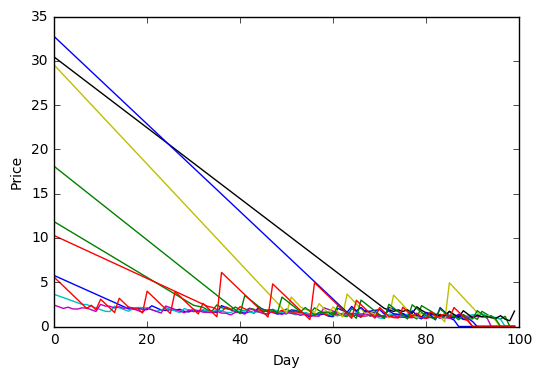

In [45]:

for cycle in range(CYCLES):
    # zero counters
    buyers[:, 3] = 0
    buyers[:, 4] = 0
    sellers[:, 3] = SEATS
    sellers[:, 4] = 0

    buyers = add_buyer_noise(buyers)
    for seller_idx in range(N_SELLERS):
        for day in range(DAYS):
            seats_left = sellers[seller_idx, 3]
            seats_record[cycle, seller_idx, day] = seats_left
            days_left = DAYS - day
            
            if seats_left <= 0:
                price = 0
            else:
                price = get_price(sellers[seller_idx, :], days_left)
            
            price_record[cycle, seller_idx, day] = price
            seats_sold, buyers = buy_tickets(buyers, seats_left, price, days_left)
            sellers[seller_idx, 3] -= seats_sold
            sellers[seller_idx, 4] += seats_sold * (price - TICKET_COST)
        
    buyers = resample_buyers(buyers)
    
    # zero counters
    buyers[:, 3] = 0
    buyers[:, 4] = 0
    sellers[:, 3] = SEATS
    sellers[:, 4] = 0
    
    sellers = add_seller_noise(sellers)
    for seller_idx in range(N_SELLERS):
        for day in range(DAYS):
            seats_left = sellers[seller_idx, 3]
            seats_record[cycle, seller_idx, day] = seats_left
            days_left = DAYS - day
            
            if seats_left <= 0:
                price = 0
            else:
                price = get_price(sellers[seller_idx, :], days_left)
            
            price_record[cycle, seller_idx, day] = price
            seats_sold, buyers = buy_tickets(buyers, seats_left, price, days_left)
            sellers[seller_idx, 3] -= seats_sold
            sellers[seller_idx, 4] += seats_sold * (price - TICKET_COST)
            
#     sellers = resample_sellers(sellers)
    buyers = resample_buyers(buyers)
    
        # zero counters
    buyers[:, 3] = 0
    buyers[:, 4] = 0
    sellers[:, 3] = SEATS
    sellers[:, 4] = 0
    
    for seller_idx in range(N_SELLERS):
        for day in range(DAYS):
            seats_left = sellers[seller_idx, 3]
            seats_record[cycle, seller_idx, day] = seats_left
            days_left = DAYS - day
            
            if seats_left <= 0:
                price = 0
            else:
                price = get_price(sellers[seller_idx, :], days_left)
            
            price_record[cycle, seller_idx, day] = price
            seats_sold, buyers = buy_tickets(buyers, seats_left, price, days_left)
            sellers[seller_idx, 3] -= seats_sold
            sellers[seller_idx, 4] += seats_sold * (price - TICKET_COST)
            
    sellers = resample_sellers(sellers)
    buyers = resample_buyers(buyers)
            
    
plt.plot(range(DAYS), price_record[0,0:10,:].T)
plt.ylabel('Price')
plt.xlabel('Day')   

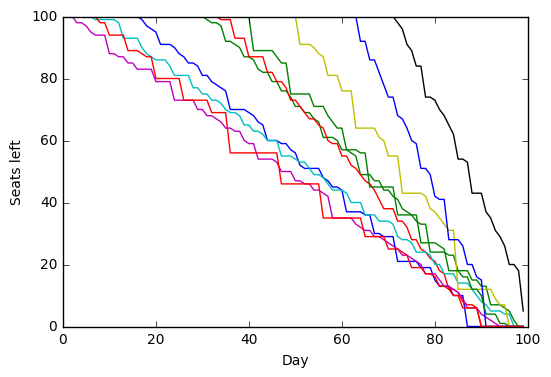

In [46]:
plt.plot(range(DAYS), seats_record[0,0:10,:].T)
plt.ylabel('Seats left')
plt.xlabel('Day')

In [47]:
sellers[:, 4]

array([ 27.20407426,  45.40992836,  31.81417256,  28.08040149,
        16.63672006,  32.3045639 ,  37.74200657, -58.10306351,
        17.16872908,  44.29986433,  18.16682794,  21.09255433,
        27.20407426,   9.2249133 ,  16.02606945,  44.29986433,
        22.21688982,  10.7657222 ,  20.16868704,  16.63672006,
         0.        ,  25.08773358,  26.26630643,  42.68852568,
         0.        ,  19.65685231,  27.20407426,  15.7331563 ,
        26.32017958,  24.72809434,  32.16545702,  17.16839108,
        17.24663261,  28.0998014 ,  10.7657222 ,   0.        ,
        44.29986433,  25.08773358,  34.62369518,  24.72809434,
        20.48443632,  24.92190601,  21.2819469 ,   0.        ,
        34.10895125,  -4.46299531,  16.63672006,  -6.91549984,
        23.71478563,  37.03032643,  37.60171042,   0.        ,
        33.15579678,  34.62369518,  21.09255433,  32.3045639 ,
        22.21688982,  16.02606945,  45.40992836,   0.        ,
        25.00351932,  16.17400464,  16.63672006,  33.15

In [48]:
buyers[:, 3].astype('int') - buyers[:, 4].astype('int')

array([   1,    6,  -18,    1,    6,    3,    6,    1,    2,   10,   -1,
          6,    2,    8,    8,    3,    1,    2,   -1,    9,    7,    8,
          6,    4,   10,    6,    2,    4,    0,    4,    5,    0,    9,
          1,    1,    8,    5,    6,    8,    7,    6,    2,    1,   -3,
          4,  -23,    5,    7,    1,   10,  -28,    3,    2,    7,    6,
        -28,    7, -113,    6,    6,   -3,    5, -139,   -1,   10,    8,
        -21,    8,  -23,    0,   -1,    5,    7,    1,    6,   -1,  -23,
         -5,   -1,   -5,    6,   -5,   -1,    0,    2,    1,    3,    3,
          7,    0,    1,    6,   -1,    5,    9,   10,    8,    8,  -28,
        -99])

In [49]:
buyers[:, 2]

array([-0.06872781, -0.01574096,  0.02902511, -0.06872781, -0.03701697,
        0.0018645 , -0.02265948, -0.06871101, -0.02949088, -0.01574096,
       -0.04803818,  0.0026077 , -0.04397354, -0.01189447, -0.02265948,
       -0.02265948, -0.05801712, -0.02969702,  0.01496578, -0.01872045,
       -0.0225734 , -0.01574096, -0.01574096, -0.05022852, -0.01189447,
       -0.02265948, -0.04803818,  0.01305439, -0.10930117, -0.04397354,
       -0.03701697, -0.20013972, -0.01225455, -0.06872781, -0.06872781,
       -0.02265948, -0.01971065,  0.0026077 , -0.01574096, -0.01505763,
        0.0026077 , -0.04081096, -0.20013972,  0.01496578,  0.01305439,
        0.03581687, -0.01971065,  0.02100937, -0.08118412, -0.01574096,
        0.03581687, -0.04105274, -0.01971065, -0.01225455, -0.02265948,
        0.03581687,  0.02100937,  0.05630154, -0.03701697, -0.03701697,
        0.01496578, -0.04081096,  0.05367642, -0.04803818, -0.01574096,
       -0.02265948,  0.02902511, -0.00297076,  0.03581687, -0.13